# COMP 8610: Assignment 1

## Question 1

### Prepare the Data
Generate 5000 synthetic data points.

In [1]:
# imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import KFold


# Set random seed
np.random.seed = 7

# Generate 5000 synthetic data points (x,y)
# Vector X
X_mu = 0
X_std = 1
X_ = np.random.normal(X_mu, X_std, size=(5000,1))

# Vector Eps
eps_mu = 0
eps_std = np.sqrt(0.25)
eps_ = np.random.normal(eps_mu, eps_std, size=(5000,1))

# Generate the Y vector
Y_ = np.zeros(shape=(1,5000))
Y_ = -1 + (0.5 * X_) - (2 * X_**2) + (0.3 * X_**3) + eps_

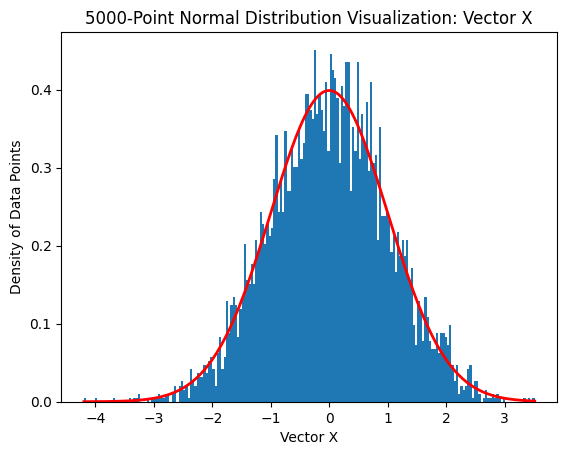

In [2]:
# Visualize the X-Distribution
_, X_bins, _ = plt.hist(X_, 200, density=True)
plt.plot(X_bins,
         1/(X_std * np.sqrt(2 * np.pi)) * np.exp(-1 * (X_bins - X_mu)**2 / (2 * X_std**2)),
         linewidth=2,
         color='r')
plt.title("5000-Point Normal Distribution Visualization: Vector X")
plt.xlabel("Vector X")
plt.ylabel("Density of Data Points")
plt.show()

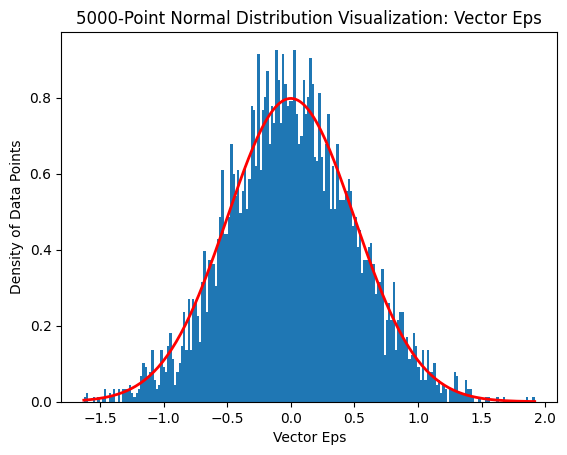

In [3]:
# Visualize the eps-distribution
_, eps_bins, _ = plt.hist(eps_, 200, density=True)
plt.plot(eps_bins,
         1/(eps_std * np.sqrt(2 * np.pi)) * np.exp(-1 * (eps_bins - eps_mu)**2 / (2 * eps_std**2)),
         linewidth=2,
         color='r')

plt.title("5000-Point Normal Distribution Visualization: Vector Eps")
plt.xlabel("Vector Eps")
plt.ylabel("Density of Data Points")
plt.show()

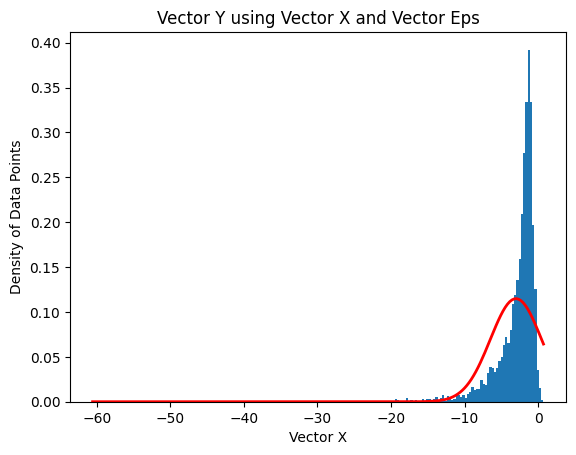

In [4]:
# Visualize the Y-distribution
Y_mu = np.mean(Y_)
Y_std = np.std(Y_)
_, Y_bins, _ = plt.hist(Y_, 200, density=True)
plt.plot(Y_bins,
         1/(Y_std * np.sqrt(2 * np.pi)) * np.exp(-1 * (Y_bins - Y_mu)**2 / (2 * Y_std**2)),
         linewidth=2,
         color='r')

plt.title("Vector Y using Vector X and Vector Eps")
plt.xlabel("Vector X")
plt.ylabel("Density of Data Points")
plt.show()

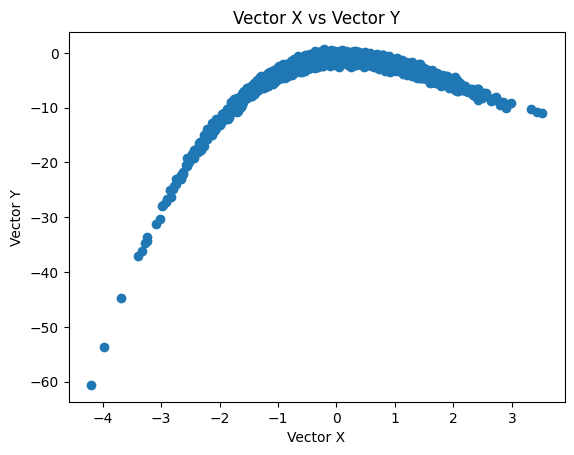

In [5]:
# Y vs X Scatterplot
plt.scatter(X_, Y_)

plt.title("Vector X vs Vector Y")
plt.xlabel("Vector X")
plt.ylabel("Vector Y")
plt.show()

### Linear Regression

In [6]:
# Ordinary Least Squares Linear Regression
class ols:
  def __init__(self, X, Y, CV=False, k=None, dim=1):
    self.dim = dim                                            # Degree
    if self.dim > 1:
      self.X = X
      for i in range(self.dim-1):
        self.X = np.append(self.X, X**(i+2), axis=1)
      self.X = np.append(np.ones((X.shape[0], 1)), self.X, axis=1)
    else:
      self.X = np.append(np.ones((X.shape[0], 1)), X, axis=1) # Predictor Maxtrix;
    self.Y = Y                                                # Response Vector
    self.beta = None                                          # Weight/Coefficient Vector
    self.k = k                                                # k-folds for CV
    self.XY_shuffled = None                                   # Internal
    self.avg_MSE = None                                       # Stats


  def fit(self):
    self.beta = np.linalg.inv(self.X.T @ self.X) @ self.X.T @ self.Y

  def predict(self, X):
    if self.beta is None:
      print("[Warning] Must fit model to data first.")
      return None
    return np.matmul(X, self.beta)

  def fit_CV(self):
    # Shuffle Data and Split into k-folds
    self.XY_shuffled = np.append(self.X, self.Y, axis=1)
    np.random.shuffle(self.XY_shuffled)
    splits = np.array_split(self.XY_shuffled, self.k, axis=0)
    
    # Train on k-1 splits, measure MSE with remaining split
    sum_MSE = 0
    sum_beta = None
    for i in range(self.k):
      # Validation Set
      X_val = np.delete(np.array(splits[i]), self.dim+1, axis=1)
      Y_val = np.delete(np.array(splits[i]), np.s_[0:self.dim+1], axis=1)
      
      # Training Set
      X_train = None
      Y_train = None
      for j in range(self.k):
        if j != i:
          if X_train is None and Y_train is None:
            X_train = np.delete(np.array(splits[j]), self.dim+1, axis=1)
            Y_train = np.delete(np.array(splits[j]), np.s_[0:self.dim+1], axis=1)
          else:
            X_j = np.delete(np.array(splits[j]), self.dim+1, axis=1)
            Y_j = np.delete(np.array(splits[j]), np.s_[0:self.dim+1], axis=1)
            X_train = np.append(X_train, X_j, axis=0)
            Y_train = np.append(Y_train, Y_j, axis=0)

      # Fit to data and update model for each fold
      beta = np.linalg.inv(X_train.T  @ X_train) @ X_train.T @ Y_train
      if sum_beta is None:
        sum_beta = beta
      else:
        sum_beta += beta
      
      # Predict and Find MSE for ith fold     
      y_pred = X_val @ beta
      MSE = (np.sum(y_pred - Y_val)**2)/y_pred.shape[0]
      sum_MSE += MSE

    self.beta = sum_beta/self.k
    self.avg_MSE = sum_MSE/self.k
    return self.avg_MSE

The MSE for the model is 3.206099061386518
3.206099061386518


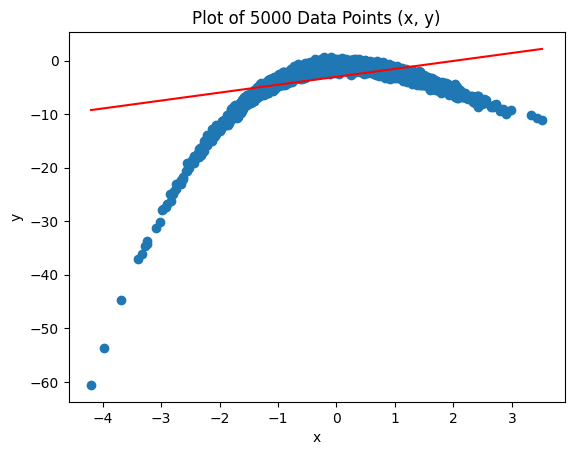

In [7]:
# 10-fold CV on complete dataset
model_10FCV = ols(X=X_, Y=Y_, k=10)
MSE = model_10FCV.fit_CV()
print("The MSE for the model is {}".format(MSE))
print(model_10FCV.avg_MSE)

# Plot the model against the dataset
y_pred = model_10FCV.predict(model_10FCV.X)
plt.scatter(X_, Y_)
x_line = np.linspace(np.min(X_), np.max(X_), 1000)
y_line = model_10FCV.beta[1]*x_line + model_10FCV.beta[0]
plt.plot(x_line, y_line, color='red')

plt.title("Plot of 5000 Data Points (x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## Polynomial Regression

In [8]:
# Linear Model using OLS method and 10-fold CV on 75% of Training Split
# Create test and training sets (25% test, 75% training)
select_test = np.random.choice([False, True], 5000, p=[0.75,0.25])

X_test = X_[select_test]
Y_test = Y_[select_test]

X_train = X_[np.logical_not(select_test)]
Y_train = Y_[np.logical_not(select_test)]

print(X_.shape)
print(X_train.shape)

(5000, 1)
(3711, 1)


In [9]:
models= []
for i in range(1,15):
  model = ols(X=X_train, Y=Y_train, k=10, dim=i)
  MSE = model.fit_CV()
  models.append(model)
  print("{}: MSE = {}".format(i, MSE))

1: MSE = 3.709289322137162
2: MSE = 0.6059245481065375
3: MSE = 0.1413677244373575
4: MSE = 0.2705409758387575
5: MSE = 0.3521236763046015
6: MSE = 0.1679441059361713
7: MSE = 0.4910896105014461
8: MSE = 0.16366481749596165
9: MSE = 0.3440799550414751
10: MSE = 0.2369387856591533
11: MSE = 0.1446770246517681
12: MSE = 0.4791814776947003
13: MSE = 0.26690378356318983
14: MSE = 0.2740991905081208


In [10]:
# The best model is the one with degree 3
# Get the weight vector
# We expect approx [ -1, 0.5, -2, 0.3 ]
models[2].beta.T

array([[-0.98171275,  0.50906119, -2.01565011,  0.29614605]])

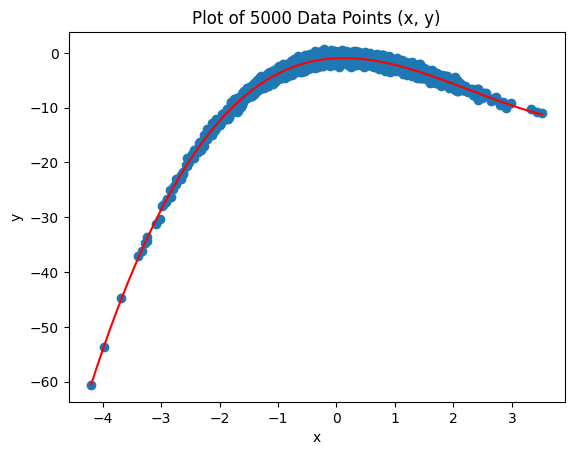

In [11]:
# Plot the model against the dataset
y_pred = models[2].predict(models[2].X)
plt.scatter(X_, Y_)
x_line = np.linspace(np.min(X_), np.max(X_), 1000)
y_line = models[2].beta[3]*x_line**3 + models[2].beta[2]*x_line**2 + models[2].beta[1]*x_line + models[2].beta[0]
plt.plot(x_line, y_line, color='red')

plt.title("Plot of 5000 Data Points (x, y)")
plt.xlabel("x")
plt.ylabel("y")
plt.show()